##Information of Epochs created (shape, dim, channels, time samples, etc)

In [ ]:
pip install mne

In [ ]:
import mne

# Step 1: Load the Cleaned EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Bandpass filter
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

# Step 2: Create 30-second Epochs
def create_epochs(raw, epoch_duration=30):
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

# Step 3: Check Shape and Dimension of Epochs
def check_epochs_shape(epochs):
    epochs_data = epochs.get_data()  # Get NumPy array representation
    print("\nDimension of a epochs_data:", epochs_data.ndim)
    print("Shape of epochs data:", epochs_data.shape)

    num_epochs, num_channels, num_samples = epochs_data.shape
    print(f"Number of epochs: {num_epochs}")
    print(f"Number of channels: {num_channels}")
    print(f"Number of time samples per epoch: {num_samples}")

    # Check shape and dimension of a single epoch
    single_epoch = epochs_data[0]  # Extract the first epoch
    print("\nDimension of a single epoch:", single_epoch.ndim)
    print("\nShape of a single epoch:", single_epoch.shape)

    num_channels_single, num_samples_single = single_epoch.shape
    print(f"Single epoch - Number of channels: {num_channels_single}")
    print(f"Single epoch - Number of time samples: {num_samples_single}")

# Main Script
if __name__ == "__main__":
    edf_file_path = "n1_cleaned_ica.edf"  # Replace with actual path

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data, epoch_duration=30)
    check_epochs_shape(epochs)

Extracting EDF parameters from /content/narco5_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12533759  =      0.000 ... 24479.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 s)

Data loaded with 5 channels and duration 408.00 minutes.
Not setting metadata
816 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 816 events and 15361 original 

#Time-Domain and Frequency-Domain Features

In [ ]:
pip install mne numpy pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 91.8 MB/s eta 0:00:00


In [ ]:
import mne
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def load_edf_file(file_path):
    """
    Load the cleaned EDF file using MNE.
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Apply a bandpass filter to retain relevant EEG bands
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

def create_epochs(raw, epoch_duration=30):
    """
    Create 30-second epochs from the raw EEG data.
    """
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

def extract_time_features(epoch_data):
    """
    Extract time-domain features for each EEG channel.
    """
    features = {}
    features['mean'] = np.mean(epoch_data, axis=1)
    features['std'] = np.std(epoch_data, axis=1)
    features['variance'] = np.var(epoch_data, axis=1)  # Added Variance Feature
    features['skew'] = skew(epoch_data, axis=1)
    features['kurtosis'] = kurtosis(epoch_data, axis=1)
    features['rms'] = np.sqrt(np.mean(np.square(epoch_data), axis=1))
    features['zcr'] = np.mean(np.diff(np.sign(epoch_data), axis=1) != 0, axis=1)
    return features

def extract_frequency_features(epoch_data, sfreq):
    """
    Extract frequency-domain features for each EEG channel.
    """
    features = {}
    frequencies, psd = welch(epoch_data, fs=sfreq, nperseg=256, axis=1)

    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)}
    total_power = np.sum(psd, axis=1)

    for band, (low, high) in bands.items():
        band_indices = np.logical_and(frequencies >= low, frequencies <= high)
        band_power = np.sum(psd[:, band_indices], axis=1)
        features[f'{band}_power'] = band_power
        features[f'{band}_relative_power'] = band_power / total_power

    return features

def extract_features(epochs, sfreq):
    """
    Extract time-domain and frequency-domain features and store them as arrays.
    """
    all_features = []
    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        time_features = extract_time_features(epoch_data)
        freq_features = extract_frequency_features(epoch_data, sfreq)
        features = {**time_features, **freq_features, 'epoch': epoch_idx}
        all_features.append(features)
        print(f"Extracted features for epoch {epoch_idx}")
    return pd.DataFrame(all_features)

def save_features_to_csv(features_df, output_csv_path):
    """
    Save extracted features to a CSV file.
    """
    features_df.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

if __name__ == "__main__":
    edf_file_path = "/content/narco4_cleaned_ica.edf"  # Replace with actual file path
    output_csv_path = "narco4_time_and_frequency_features.csv"

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data)
    sfreq = raw_data.info['sfreq']
    features_df = extract_features(epochs, sfreq)
    save_features_to_csv(features_df, output_csv_path)

Extracting EDF parameters from /content/narco4_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20107263  =      0.000 ... 39271.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 s)

Data loaded with 5 channels and duration 654.53 minutes.
Not setting metadata
1309 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1309 events and 15361 origina

#Hjorth and Entropy Features

In [ ]:
pip install mne numpy pandas scipy antropy

####Method1: Calculate and store for each channel individually, then combine in arrays

In [ ]:
import mne
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from antropy import perm_entropy, app_entropy, sample_entropy, spectral_entropy

def load_edf_file(file_path):
    """
    Load the cleaned EDF file using MNE.
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Apply a bandpass filter to retain relevant EEG bands
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

def create_epochs(raw, epoch_duration=30):
    """
    Create 30-second epochs from the raw EEG data.
    """
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

def extract_hjorth_entropy_features(epoch_data, sfreq):
    """
    Extract Hjorth and entropy features for each EEG channel.
    """
    num_channels, num_samples = epoch_data.shape
    features = {}

    for ch in range(num_channels):
        signal = epoch_data[ch]
        diff1 = np.diff(signal, n=1, prepend=signal[0])
        diff2 = np.diff(diff1, n=1, prepend=diff1[0])

        var_zero = np.var(signal)
        var_diff1 = np.var(diff1)
        var_diff2 = np.var(diff2)

        features[f'channel_{ch}_hjorth_activity'] = var_zero
        features[f'channel_{ch}_hjorth_mobility'] = np.sqrt(var_diff1 / (var_zero + 1e-12))
        features[f'channel_{ch}_hjorth_complexity'] = (
            np.sqrt(var_diff2 / (var_diff1 + 1e-12)) / (features[f'channel_{ch}_hjorth_mobility'] + 1e-12)
        )

        features[f'channel_{ch}_perm_entropy'] = perm_entropy(signal, normalize=True)
        features[f'channel_{ch}_approx_entropy'] = app_entropy(signal, order=2, metric='chebyshev')
        features[f'channel_{ch}_sample_entropy'] = sample_entropy(signal)
        features[f'channel_{ch}_shannon_entropy'] = spectral_entropy(signal, sfreq, method='welch')

    return features

def extract_features(epochs, sfreq):
    """
    Extract Hjorth and entropy features from EEG epochs and return as a DataFrame.
    """
    all_features = []

    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        features = extract_hjorth_entropy_features(epoch_data, sfreq)
        features['epoch'] = epoch_idx
        all_features.append(features)
        print(f"Extracted features for epoch {epoch_idx}")

    return pd.DataFrame(all_features)

def save_features_to_csv(features_df, output_csv_path):
    """
    Save extracted features to a CSV file.
    """
    features_df.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

if __name__ == "__main__":
    edf_file_path = "narco4_cleaned_ica.edf"  # Replace with actual path
    output_csv_path = "narco4_hjorth_entropy_features.csv"

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data)
    sfreq = raw_data.info['sfreq']  # Fix: Pass sampling frequency
    features_df = extract_features(epochs, sfreq)
    save_features_to_csv(features_df, output_csv_path)

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
df = pd.read_csv("/content/narco4_hjorth_entropy_features.csv")  # Replace with your file path

# List of feature types
feature_types = [
    "hjorth_activity", "hjorth_mobility", "hjorth_complexity",
    "perm_entropy", "approx_entropy", "sample_entropy", "shannon_entropy"
]

# Combine features into arrays for all channels
for feature in feature_types:
    df[feature] = df[[f"channel_{i}_{feature}" for i in range(5)]].apply(lambda x: np.array(x), axis=1)

# Drop original channel-specific columns
columns_to_drop = [f"channel_{i}_{feature}" for i in range(5) for feature in feature_types]
df.drop(columns=columns_to_drop, inplace=True)

# Save the transformed data
df.to_csv("narco4_hjorth_entropy.csv", index=False)  # Replace with desired output file name

# Display the transformed DataFrame
print(df.head())


   epoch                                    hjorth_activity  \
0      0  [1.740573226223452e-10, 2.46144811829243e-10, ...   
1      1  [3.2792694308810277e-10, 4.524083629941322e-10...   
2      2  [2.0689965081263208e-10, 2.843237865426565e-10...   
3      3  [1.8850164710511669e-10, 2.6028596575251635e-1...   
4      4  [2.5580079438023545e-10, 3.519473865740273e-10...   

                                     hjorth_mobility  \
0  [0.1176115838649816, 0.1159004262490345, 0.117...   
1  [0.1315231134914319, 0.1308112291465388, 0.131...   
2  [0.1199737758530705, 0.1197314391015831, 0.120...   
3  [0.1062553646586041, 0.1067179866174656, 0.106...   
4  [0.1033387733385478, 0.1035392878121843, 0.103...   

                                   hjorth_complexity  \
0  [1.8775671858758216, 1.986966554237397, 1.9898...   
1  [1.889181013549545, 1.937544852488969, 1.94131...   
2  [1.9621782350451935, 2.0341432065992926, 2.051...   
3  [2.1445897033038257, 2.2364131010756427, 2.271...   
4  [

####Method2: Combined the above process into a single snippet

In [ ]:
import mne
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from antropy import perm_entropy, app_entropy, sample_entropy, spectral_entropy

def load_edf_file(file_path):
    """
    Load the cleaned EDF file using MNE.
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Apply a bandpass filter to retain relevant EEG bands
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

def create_epochs(raw, epoch_duration=30):
    """
    Create 30-second epochs from the raw EEG data.
    """
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

def extract_hjorth_entropy_features(epoch_data, sfreq):
    """
    Extract Hjorth and entropy features for each EEG channel.
    """
    num_channels, num_samples = epoch_data.shape
    features = {}

    for ch in range(num_channels):
        signal = epoch_data[ch]
        diff1 = np.diff(signal, n=1, prepend=signal[0])
        diff2 = np.diff(diff1, n=1, prepend=diff1[0])

        var_zero = np.var(signal)
        var_diff1 = np.var(diff1)
        var_diff2 = np.var(diff2)

        features[f'channel_{ch}_hjorth_activity'] = var_zero
        features[f'channel_{ch}_hjorth_mobility'] = np.sqrt(var_diff1 / (var_zero + 1e-12))
        features[f'channel_{ch}_hjorth_complexity'] = (
            np.sqrt(var_diff2 / (var_diff1 + 1e-12)) / (features[f'channel_{ch}_hjorth_mobility'] + 1e-12)
        )

        features[f'channel_{ch}_perm_entropy'] = perm_entropy(signal, normalize=True)
        features[f'channel_{ch}_approx_entropy'] = app_entropy(signal, order=2, metric='chebyshev')
        features[f'channel_{ch}_sample_entropy'] = sample_entropy(signal)
        features[f'channel_{ch}_shannon_entropy'] = spectral_entropy(signal, sfreq, method='welch')

    return features

def extract_features(epochs, sfreq):
    """
    Extract Hjorth and entropy features from EEG epochs and return as a DataFrame.
    """
    all_features = []

    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        features = extract_hjorth_entropy_features(epoch_data, sfreq)
        features['epoch'] = epoch_idx
        all_features.append(features)
        print(f"Extracted features for epoch {epoch_idx}")

    return pd.DataFrame(all_features)

def transform_features_to_arrays(features_df):
    """
    Transform features to store data of each feature across all channels in an array.
    """
    feature_types = [
        "hjorth_activity", "hjorth_mobility", "hjorth_complexity",
        "perm_entropy", "approx_entropy", "sample_entropy", "shannon_entropy"
    ]

    for feature in feature_types:
        features_df[feature] = features_df[[f"channel_{i}_{feature}" for i in range(5)]].apply(lambda x: np.array(x), axis=1)

    columns_to_drop = [f"channel_{i}_{feature}" for i in range(5) for feature in feature_types]
    features_df.drop(columns=columns_to_drop, inplace=True)

    return features_df

def save_features_to_csv(features_df, output_csv_path):
    """
    Save extracted and transformed features to a CSV file.
    """
    features_df.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

if __name__ == "__main__":
    edf_file_path = "narco4_cleaned_ica.edf"  # Replace with actual path
    output_csv_path = "narco4_hjorth_entropy.csv"

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data)
    sfreq = raw_data.info['sfreq']  # Fix: Pass sampling frequency
    features_df = extract_features(epochs, sfreq)
    transformed_df = transform_features_to_arrays(features_df)
    save_features_to_csv(transformed_df, output_csv_path)

Extracting EDF parameters from /content/narco4_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20107263  =      0.000 ... 39271.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 s)

Data loaded with 5 channels and duration 654.53 minutes.
Not setting metadata
1309 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1309 events and 15361 origina

# Time-frequency Features (Wavelet, STFT)

In [ ]:
pip install mne numpy pandas scipy PyWavelets

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
            

### Method-1 : Data stored in csv in array for each feature

In [ ]:
import mne
import numpy as np
import pandas as pd
import scipy.signal as signal
import pywt  # For wavelet transform

# Step 1: Load the Cleaned EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Bandpass filter
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

# Step 2: Create 30-second Epochs
def create_epochs(raw, epoch_duration=30):
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

# Step 3: Compute STFT Features
def compute_stft_features(epoch_data, sfreq):
    stft_mean_powers = []
    for i in range(epoch_data.shape[0]):  # Loop through each channel
        f, t, Zxx = signal.stft(epoch_data[i], fs=sfreq, nperseg=256)
        stft_mean_power = np.mean(np.abs(Zxx))  # Mean power of STFT magnitude
        stft_mean_powers.append(stft_mean_power)
    return stft_mean_powers  # Return an array of 5 values

# Step 4: Compute Wavelet Transform Features
def compute_wavelet_features(epoch_data):
    wavelet_mean_powers = []
    wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet for time-frequency analysis

    for i in range(epoch_data.shape[0]):  # Loop through each channel
        coeffs, _ = pywt.cwt(epoch_data[i], scales=np.arange(1, 128), wavelet=wavelet)
        wavelet_mean_power = np.mean(np.abs(coeffs))  # Mean power of wavelet transform
        wavelet_mean_powers.append(wavelet_mean_power)
    return wavelet_mean_powers  # Return an array of 5 values

# Step 5: Extract Time-Frequency Features for All Epochs
def extract_time_frequency_features(epochs):
    sfreq = epochs.info['sfreq']
    all_features = []

    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        stft_features = compute_stft_features(epoch_data, sfreq)
        wavelet_features = compute_wavelet_features(epoch_data)

        # Store as arrays in a single row
        time_freq_features = {
          'epoch': epoch_idx,
          'stft_mean_power': [float(val) for val in stft_features],
          'wavelet_mean_power': [float(val) for val in wavelet_features]
      }

        all_features.append(time_freq_features)

        # Print progress tracking message
        print(f"Extracted features for epoch {epoch_idx}")

    return pd.DataFrame(all_features)

# Step 6: Save Features to CSV
def save_features_to_csv(features_df, output_csv_path):
    features_df.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

# Main Script
if __name__ == "__main__":
    edf_file_path = "narco4_cleaned_ica.edf"  # Replace with actual path
    output_csv_path = "narco4_STFT_Wavelet_features.csv"

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data, epoch_duration=30)
    features_df = extract_time_frequency_features(epochs)
    save_features_to_csv(features_df, output_csv_path)

Extracting EDF parameters from /content/narco4_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20107263  =      0.000 ... 39271.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 s)

Data loaded with 5 channels and duration 654.53 minutes.
Not setting metadata
1309 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1309 events and 15361 origina

### Method-2 : Data stored individually for each channel for a feature

In [ ]:
import mne
import numpy as np
import pandas as pd
import scipy.signal as signal
import pywt  # For wavelet transform

# Step 1: Load the Cleaned EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Bandpass filter
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

# Step 2: Create 30-second Epochs
def create_epochs(raw, epoch_duration=30):
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

# Step 3: Compute STFT Features
def compute_stft_features(epoch_data, sfreq, channel_names):
    stft_features = {}
    for i, channel_name in enumerate(channel_names):
        f, t, Zxx = signal.stft(epoch_data[i], fs=sfreq, nperseg=256)
        stft_mean_power = np.mean(np.abs(Zxx))  # Mean power of STFT magnitude
        stft_features[f'stft_{channel_name}_mean_power'] = stft_mean_power
    return stft_features

# Step 4: Compute Wavelet Transform Features
def compute_wavelet_features(epoch_data, channel_names):
    wavelet_features = {}
    wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet for time-frequency analysis

    for i, channel_name in enumerate(channel_names):
        coeffs, _ = pywt.cwt(epoch_data[i], scales=np.arange(1, 128), wavelet=wavelet)
        wavelet_mean_power = np.mean(np.abs(coeffs))  # Mean power of wavelet transform
        wavelet_features[f'wavelet_{channel_name}_mean_power'] = wavelet_mean_power
    return wavelet_features

# Step 5: Extract Time-Frequency Features for All Epochs
def extract_time_frequency_features(epochs, channel_names):
    sfreq = epochs.info['sfreq']
    all_features = []

    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        stft_features = compute_stft_features(epoch_data, sfreq, channel_names)
        wavelet_features = compute_wavelet_features(epoch_data, channel_names)

        # Combine features
        time_freq_features = {**stft_features, **wavelet_features}
        time_freq_features['epoch'] = epoch_idx
        all_features.append(time_freq_features)

        # Print progress tracking message
        print(f"Extracted features for epoch {epoch_idx}")

    return pd.DataFrame(all_features)

# Step 6: Save Features to CSV
def save_features_to_csv(features_df, output_csv_path):
    features_df.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

# Main Script
if __name__ == "__main__":
    edf_file_path = "n11_cleaned_ica.edf"  # Replace with actual path
    output_csv_path = "n11_STFT_Wavelet_features.csv"

    channel_names = ["Fp2", "F4", "C4", "P4", "O2"]  # Replace with actual channel order

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data, epoch_duration=30)
    features_df = extract_time_frequency_features(epochs, channel_names)
    save_features_to_csv(features_df, output_csv_path)

# Non-linear Features

In [ ]:
pip install mne scipy numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.7 MB/s eta 0:00:00


In [ ]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import detrend
from numpy.linalg import LinAlgError

# Step 1: Load the Cleaned EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Bandpass filter
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

# Step 2: Create 30-second Epochs
def create_epochs(raw, epoch_duration=30):
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

# Step 3: Compute Higuchi's Fractal Dimension (HFD)
def higuchi_fd(data, kmax=10):
    """Computes Higuchi's Fractal Dimension for a given time series."""
    n = len(data)
    lk = np.zeros(kmax)
    xk = np.zeros(kmax)

    for k in range(1, kmax+1):
        lm = []
        for m in range(k):
            Lm = np.sum(np.abs(np.diff(data[m:n:k]))) / ((n - m) / k)
            lm.append(Lm)
        lk[k-1] = np.mean(lm)
        xk[k-1] = np.log(1.0 / k)

    try:
        higuchi, _ = np.polyfit(xk, np.log(lk), 1)
        return abs(higuchi)
    except LinAlgError:
        return np.nan  # Return NaN if fitting fails

# Step 4: Compute Largest Lyapunov Exponent (LLE)
def lyapunov_exponent(data, tau=1, d=2):
    """Computes an approximation of the largest Lyapunov Exponent."""
    n = len(data)
    if n < (d + 1) * tau:
        return np.nan  # Not enough data points

    X = np.array([data[i: n - (d * tau) + i: tau] for i in range(d + 1)]).T
    X = detrend(X, axis=0)

    try:
        w, v = np.linalg.eig(np.cov(X.T))
        return np.max(np.log(np.abs(w)))
    except LinAlgError:
        return np.nan  # Return NaN if eigenvalue computation fails

# Step 5: Compute Hurst Exponent (H)
def hurst_exponent(data):
    """Computes Hurst Exponent using R/S analysis."""
    N = len(data)
    T = np.arange(1, N + 1)
    Y = np.cumsum(data - np.mean(data))
    R = np.maximum.accumulate(Y) - np.minimum.accumulate(Y)
    S = np.std(data)

    if S == 0:
        return np.nan  # Avoid division by zero

    R_S = R / S
    R_S[R_S == 0] = np.nan  # Handle zero division
    H, _ = np.polyfit(np.log(T[1:]), np.log(R_S[1:]), 1)
    return abs(H)

# Step 6: Extract Non-Linear Features for Each Epoch
# Step 6: Extract Non-Linear Features for Each Epoch
def extract_nonlinear_features(epochs):
    all_features = []

    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        hfd_values = [float(higuchi_fd(epoch_data[i])) for i in range(epoch_data.shape[0])]
        lle_values = [float(lyapunov_exponent(epoch_data[i])) for i in range(epoch_data.shape[0])]
        hurst_values = [float(hurst_exponent(epoch_data[i])) for i in range(epoch_data.shape[0])]

        nonlinear_features = {
            'epoch': epoch_idx,
            'higuchi_fd': hfd_values,  # Convert to Python float
            'lyapunov_exponent': lle_values,  # Convert to Python float
            'hurst_exponent': hurst_values  # Convert to Python float
        }
        all_features.append(nonlinear_features)

        print(f"Extracted features for epoch {epoch_idx}")  # Progress tracking

    return pd.DataFrame(all_features)

# Step 7: Save Features to CSV
def save_features_to_csv(features_df, output_csv_path):
    features_df.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

# Main Script
if __name__ == "__main__":
    edf_file_path = "narco4_cleaned_ica.edf"  # Replace with actual path
    output_csv_path = "narco4_nonlinear_features.csv"

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data, epoch_duration=30)
    features_df = extract_nonlinear_features(epochs)
    save_features_to_csv(features_df, output_csv_path)

Extracting EDF parameters from /content/narco4_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20107263  =      0.000 ... 39271.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 s)

Data loaded with 5 channels and duration 654.53 minutes.
Not setting metadata
1309 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1309 events and 15361 origina

### Lyapunov Exponent

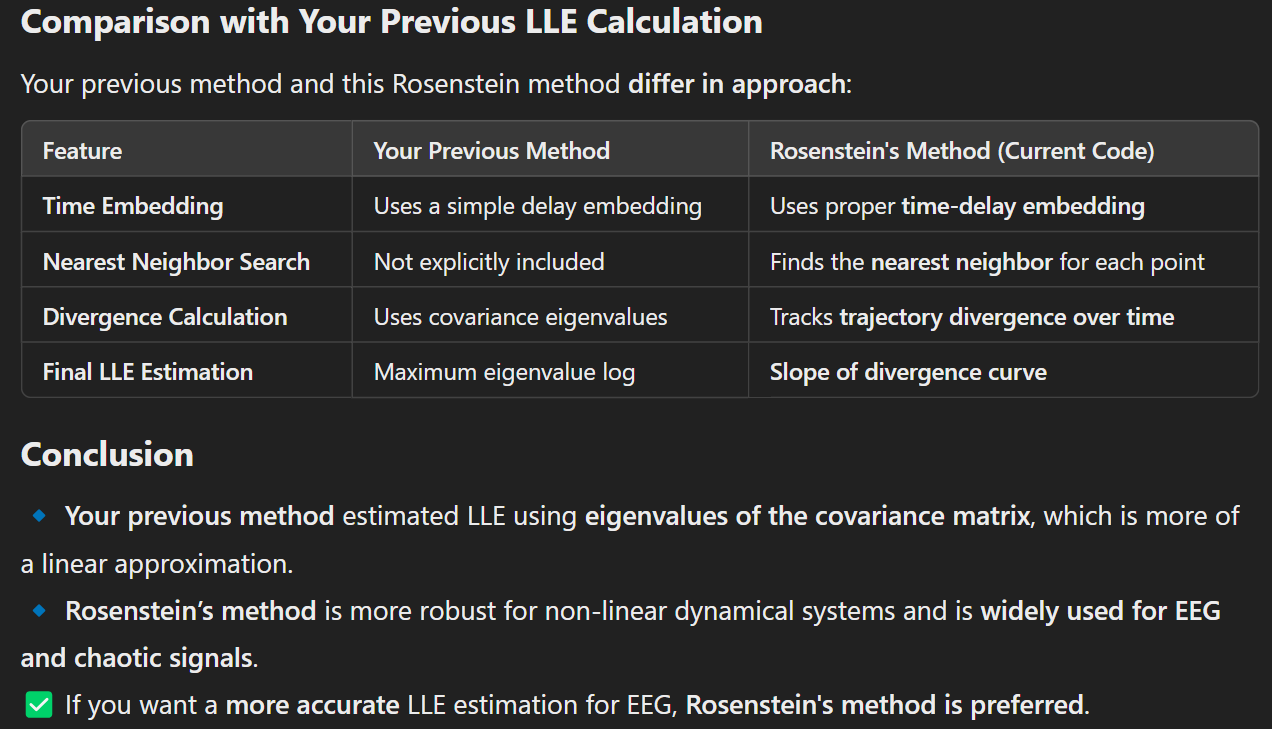

In [ ]:
import mne
import h5py
import numpy as np

# Step 1: Load the Cleaned EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)  # Load entire data into memory
    raw.filter(0.5, 45)  # Bandpass filter
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

# Step 2: Create 30-second Epochs
def create_epochs(raw, epoch_duration=30):
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

# Step 3: Save Epochs to HDF5 File
def save_epochs_hdf5(epochs, output_hdf5_path):
    with h5py.File(output_hdf5_path, "w") as f:
        data = epochs.get_data()
        f.create_dataset("epochs", data=data)
    print(f"Epochs saved to {output_hdf5_path}")

# Main Execution
if __name__ == "__main__":
    edf_file_path = "n10_cleaned_ica.edf"  # Replace with actual path
    hdf5_output_path = "n10_epochs.hdf5"

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data, epoch_duration=30)
    save_epochs_hdf5(epochs, hdf5_output_path)

Extracting EDF parameters from /content/n10_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15052799  =      0.000 ... 29399.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 s)

Data loaded with 5 channels and duration 490.00 minutes.
Not setting metadata
980 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 980 events and 15361 original tim

#### Method1: Compute all

In [ ]:
import numpy as np
import pandas as pd
import h5py
import gc
import csv
from scipy.signal import detrend
from numpy.linalg import LinAlgError

# Step 1: Time-Delay Embedding
def time_delay_embedding(signal, dimension, delay):
    n = len(signal)
    max_length = n - (dimension - 1) * delay
    if max_length <= 0:
        return None  # Avoid errors if data is too short

    return np.array([signal[i:i + max_length:delay] for i in range(dimension)], dtype=np.float32).T

# Step 2: Compute Largest Lyapunov Exponent (LLE)
def lyapunov_exponent(signal, dimension=5, delay=1, num_points=50):
    embedded = time_delay_embedding(signal, dimension, delay)
    if embedded is None:
        return np.nan

    distances = np.linalg.norm(embedded[:, None] - embedded, axis=2)
    np.fill_diagonal(distances, np.inf)
    nearest_neighbors = np.argmin(distances, axis=1)

    divergence = np.zeros(num_points, dtype=np.float32)
    for i in range(num_points):
        valid_count, temp_div = 0, 0
        for j in range(len(embedded) - i):
            index1, index2 = j, nearest_neighbors[j]
            if index2 + i < len(embedded):
                d = np.linalg.norm(embedded[index1 + i] - embedded[index2 + i])
                if d > 0:
                    temp_div += np.log(d)
                    valid_count += 1
        if valid_count > 0:
            divergence[i] = temp_div / valid_count

    time_vector = np.arange(1, num_points + 1)
    coeffs = np.polyfit(time_vector, divergence, 1)
    return coeffs[0]

# Step 3: Process Epochs One-by-One (Optimized)
def process_epochs_and_save(hdf5_path, output_csv_path):
    with h5py.File(hdf5_path, "r") as f, open(output_csv_path, "w", newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["epoch", "channel", "lyapunov_exponent"])  # CSV Header

        total_epochs = f["epochs"].shape[0]
        num_channels = f["epochs"].shape[1]

        for epoch_idx in range(total_epochs):
            for channel_idx in range(num_channels):
                epoch_channel_data = f["epochs"][epoch_idx, channel_idx, :].astype(np.float32)  # Load one channel
                lle_value = lyapunov_exponent(epoch_channel_data)

                writer.writerow([epoch_idx, channel_idx, lle_value])  # Write to CSV immediately
                print(f"Processed Epoch {epoch_idx}, Channel {channel_idx}")

            gc.collect()  # Free memory after processing each epoch

# Main Execution
if __name__ == "__main__":
    hdf5_input_path = "narco3_epochs.hdf5"
    output_csv_path = "narco3_lyapunov_exponent.csv"

    process_epochs_and_save(hdf5_input_path, output_csv_path)

Processed Epoch 0, Channel 0
Processed Epoch 0, Channel 1
Processed Epoch 0, Channel 2
Processed Epoch 0, Channel 3
Processed Epoch 0, Channel 4
Processed Epoch 1, Channel 0
Processed Epoch 1, Channel 1
Processed Epoch 1, Channel 2
Processed Epoch 1, Channel 3
Processed Epoch 1, Channel 4
Processed Epoch 2, Channel 0
Processed Epoch 2, Channel 1
Processed Epoch 2, Channel 2
Processed Epoch 2, Channel 3
Processed Epoch 2, Channel 4
Processed Epoch 3, Channel 0
Processed Epoch 3, Channel 1
Processed Epoch 3, Channel 2
Processed Epoch 3, Channel 3
Processed Epoch 3, Channel 4
Processed Epoch 4, Channel 0
Processed Epoch 4, Channel 1
Processed Epoch 4, Channel 2
Processed Epoch 4, Channel 3
Processed Epoch 4, Channel 4
Processed Epoch 5, Channel 0
Processed Epoch 5, Channel 1
Processed Epoch 5, Channel 2
Processed Epoch 5, Channel 3
Processed Epoch 5, Channel 4
Processed Epoch 6, Channel 0
Processed Epoch 6, Channel 1
Processed Epoch 6, Channel 2
Processed Epoch 6, Channel 3
Processed Epoc

KeyboardInterrupt: 

#### Method2: Set the Starting epoch

In [ ]:
import numpy as np
import pandas as pd
import h5py
import gc
import csv
from scipy.signal import detrend
from numpy.linalg import LinAlgError

# Step 1: Time-Delay Embedding
def time_delay_embedding(signal, dimension, delay):
    n = len(signal)
    max_length = n - (dimension - 1) * delay
    if max_length <= 0:
        return None  # Avoid errors if data is too short

    return np.array([signal[i:i + max_length:delay] for i in range(dimension)], dtype=np.float32).T

# Step 2: Compute Largest Lyapunov Exponent (LLE)
def lyapunov_exponent(signal, dimension=5, delay=1, num_points=50):
    embedded = time_delay_embedding(signal, dimension, delay)
    if embedded is None:
        return np.nan

    distances = np.linalg.norm(embedded[:, None] - embedded, axis=2)
    np.fill_diagonal(distances, np.inf)
    nearest_neighbors = np.argmin(distances, axis=1)

    divergence = np.zeros(num_points, dtype=np.float32)
    for i in range(num_points):
        valid_count, temp_div = 0, 0
        for j in range(len(embedded) - i):
            index1, index2 = j, nearest_neighbors[j]
            if index2 + i < len(embedded):
                d = np.linalg.norm(embedded[index1 + i] - embedded[index2 + i])
                if d > 0:
                    temp_div += np.log(d)
                    valid_count += 1
        if valid_count > 0:
            divergence[i] = temp_div / valid_count

    time_vector = np.arange(1, num_points + 1)
    coeffs = np.polyfit(time_vector, divergence, 1)
    return coeffs[0]

# Step 3: Process Epochs One-by-One (Optimized)
def process_epochs_and_save(hdf5_path, output_csv_path, start_epoch=0):
    with h5py.File(hdf5_path, "r") as f, open(output_csv_path, "a", newline='') as csv_file:
        writer = csv.writer(csv_file)

        # If the file is empty, write the header
        if csv_file.tell() == 0:
            writer.writerow(["epoch", "channel", "lyapunov_exponent"])  # CSV Header

        total_epochs = f["epochs"].shape[0]
        num_channels = f["epochs"].shape[1]

        for epoch_idx in range(start_epoch, total_epochs):  # Start from given epoch
            for channel_idx in range(num_channels):
                epoch_channel_data = f["epochs"][epoch_idx, channel_idx, :].astype(np.float32)  # Load one channel
                lle_value = lyapunov_exponent(epoch_channel_data)

                writer.writerow([epoch_idx, channel_idx, lle_value])  # Write to CSV immediately
                csv_file.flush()  # Ensure data is written to disk

                print(f"Processed Epoch {epoch_idx}, Channel {channel_idx}")

            gc.collect()  # Free memory after processing each epoch

# Main Execution
if __name__ == "__main__":
    hdf5_input_path = "n5_epochs.hdf5"
    output_csv_path = "n5_lyapunov_exponent.csv"
    start_epoch = 466  # Change this to the epoch you want to start from

    process_epochs_and_save(hdf5_input_path, output_csv_path, start_epoch)

Processed Epoch 466, Channel 0
Processed Epoch 466, Channel 1
Processed Epoch 466, Channel 2
Processed Epoch 466, Channel 3
Processed Epoch 466, Channel 4
Processed Epoch 467, Channel 0
Processed Epoch 467, Channel 1


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Load the Lyapunov exponent data
df_lyapunov = pd.read_csv("/content/narco4/narco4_lyapunov_exponent.csv")

# Group by epoch and convert 'channel' and 'lyapunov_exponent' into arrays
df_lyapunov_pivot = df_lyapunov.groupby("epoch").agg({
    "channel": list,  # Store channel numbers as an array
    "lyapunov_exponent": list  # Store corresponding Lyapunarco1v exponents as an array
}).reset_index()

# Save the transformed data
df_lyapunov_pivot.to_csv("/content/narco4/narco4_lyapunov_transformed.csv", index=False)

# Display the first few rows to verify
print(df_lyapunov_pivot.shape)

(1309, 3)


#Coherence Features

In [ ]:
pip install mne scipy numpy pandas

In [ ]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence

# Install required dependencies
# !pip install mne numpy pandas scipy

# Step 1: Load the Cleaned EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(0.5, 45)  # Bandpass filter
    print(f"Data loaded with {raw.info['nchan']} channels and duration {raw.times[-1]/60:.2f} minutes.")
    return raw

# Step 2: Create 30-second Epochs
def create_epochs(raw, epoch_duration=30):
    events = mne.make_fixed_length_events(raw, duration=epoch_duration)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=epoch_duration, baseline=None, preload=True)
    print(f"Created {len(epochs)} epochs of {epoch_duration} seconds each.")
    return epochs

# Step 3: Extract Coherence Features
def extract_coherence_features(epoch_data, sfreq, channel_names):
    features = {}
    num_channels = len(channel_names)

    for i in range(num_channels):
        for j in range(i + 1, num_channels):  # Avoid duplicates and self-coherence
            f, Cxy = coherence(epoch_data[i], epoch_data[j], fs=sfreq, nperseg=256)
            features[f'coherence_{channel_names[i]}_{channel_names[j]}_mean'] = np.mean(Cxy)
            features[f'coherence_{channel_names[i]}_{channel_names[j]}_max'] = np.max(Cxy)

    return features

# Step 4: Extract Features for All Epochs
def extract_features(epochs, channel_names):
    sfreq = epochs.info['sfreq']
    all_features = []

    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        coherence_features = extract_coherence_features(epoch_data, sfreq, channel_names)
        coherence_features['epoch'] = epoch_idx
        all_features.append(coherence_features)

    return pd.DataFrame(all_features)

# Step 5: Save Features to CSV
def save_features_to_csv(features_df, output_csv_path):
    features_df.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

# Main Script
if __name__ == "__main__":
    edf_file_path = "narco4_cleaned_ica.edf"  # Replace with actual path
    output_csv_path = "narco4_coherence_features.csv"

    channel_names = ["Fp2", "F4", "C4", "P4", "O2"]  # Replace with actual channel order

    raw_data = load_edf_file(edf_file_path)
    epochs = create_epochs(raw_data, epoch_duration=30)
    features_df = extract_features(epochs, channel_names)
    save_features_to_csv(features_df, output_csv_path)

Extracting EDF parameters from /content/narco4_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20107263  =      0.000 ... 39271.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 s)

Data loaded with 5 channels and duration 654.53 minutes.
Not setting metadata
1309 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1309 events and 15361 origina

#Spindle features

In [ ]:
pip install mne pandas numpy yasa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00


In [ ]:
pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyriemann 0.8 requires numpy>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import mne
import pandas as pd
import numpy as np
import yasa

# Function to Load EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    return raw

# Function to Extract Spindle Features
def extract_spindle_features(raw):
    spindles = yasa.spindles_detect(raw, freq_sp=(11, 16), duration=(0.5, 2.5))
    spindles_summary = spindles.summary()

    if 'Count' in spindles_summary.columns:
        spindle_count = spindles_summary.groupby('Channel')['Count'].sum().values
    else:
        spindle_count = len(spindles_summary)

    return {
        'spindle_count': spindle_count,
        'mean_spindle_duration': spindles_summary['Duration'].mean() if not spindles_summary.empty else 0,
        'spindle_density': spindles_summary['Density'].mean() if 'Density' in spindles_summary.columns else 0,
        'spindle_frequency': spindles_summary['Frequency'].mean() if 'Frequency' in spindles_summary.columns else 0
    }

# Function to Save Spindle Features to CSV
def save_spindle_features_to_csv(spindle_features, output_csv_path):
    spindle_df = pd.DataFrame([spindle_features])
    spindle_df.to_csv(output_csv_path, index=False)
    print(f"Spindle features saved to {output_csv_path}")

# Main Script
if __name__ == "__main__":
    edf_file_path = "/content/narco4_cleaned_ica.edf"  # Replace with the actual path
    spindle_csv_path = "narco4_spindle_features.csv"

    raw_data = load_edf_file(edf_file_path)
    spindle_features = extract_spindle_features(raw_data)
    save_spindle_features_to_csv(spindle_features, spindle_csv_path)

Extracting EDF parameters from /content/narco2_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17643519  =      0.000 ... 34459.998 secs...
Spindle features saved to narco2_spindle_features.csv


In [ ]:
import mne
import pandas as pd
import numpy as np
import yasa

# Function to Load EDF File
def load_edf_file(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=False)  # Load without preloading to save memory
    return raw

# Function to Process a Segment of the EDF File
def process_segment(raw, start, stop):
    raw_segment = raw.copy().crop(tmin=start, tmax=stop).load_data()  # Load only needed data
    spindles = yasa.spindles_detect(raw_segment, freq_sp=(11, 16), duration=(0.5, 2.5))
    spindles_summary = spindles.summary()

    # Extract Features
    if 'Count' in spindles_summary.columns:
        spindle_count = spindles_summary.groupby('Channel')['Count'].sum().values
    else:
        spindle_count = len(spindles_summary)

    return {
        'spindle_count': np.sum(spindle_count) if isinstance(spindle_count, np.ndarray) else spindle_count,
        'mean_spindle_duration': spindles_summary['Duration'].mean() if not spindles_summary.empty else 0,
        'spindle_density': spindles_summary['Density'].mean() if 'Density' in spindles_summary.columns else 0,
        'spindle_frequency': spindles_summary['Frequency'].mean() if 'Frequency' in spindles_summary.columns else 0
    }

# Function to Process Large EDF File in Parts
def extract_spindle_features_in_chunks(raw, num_chunks=3):
    total_duration = raw.times[-1]  # Get total duration in seconds
    chunk_size = total_duration / num_chunks  # Divide file into equal parts

    all_features = []
    for i in range(num_chunks):
        start = i * chunk_size
        stop = min((i + 1) * chunk_size, total_duration)  # Ensure we don't go beyond file duration
        print(f"Processing chunk {i+1}/{num_chunks}: {start:.2f}s to {stop:.2f}s")

        chunk_features = process_segment(raw, start, stop)
        all_features.append(chunk_features)

    # Aggregate Results (Mean/Average across chunks)
    final_features = {
        'spindle_count': sum(f['spindle_count'] for f in all_features),
        'mean_spindle_duration': np.mean([f['mean_spindle_duration'] for f in all_features]),
        'spindle_density': np.mean([f['spindle_density'] for f in all_features]),
        'spindle_frequency': np.mean([f['spindle_frequency'] for f in all_features])
    }
    return final_features

# Function to Save Spindle Features to CSV
def save_spindle_features_to_csv(spindle_features, output_csv_path):
    spindle_df = pd.DataFrame([spindle_features])
    spindle_df.to_csv(output_csv_path, index=False)
    print(f"✅ Spindle features saved to {output_csv_path}")

# Main Script
if __name__ == "__main__":
    edf_file_path = "/content/narco4_cleaned_ica.edf"  # Replace with the actual path
    spindle_csv_path = "narco4_spindle_features.csv"

    raw_data = load_edf_file(edf_file_path)
    spindle_features = extract_spindle_features_in_chunks(raw_data, num_chunks=3)  # Divide into 3 parts
    save_spindle_features_to_csv(spindle_features, spindle_csv_path)

Extracting EDF parameters from /content/narco4_cleaned_ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing chunk 1/3: 0.00s to 13090.67s
Reading 0 ... 6702421  =      0.000 ... 13090.666 secs...
Processing chunk 2/3: 13090.67s to 26181.33s
Reading 0 ... 6702421  =      0.000 ... 13090.666 secs...
Processing chunk 3/3: 26181.33s to 39272.00s
Reading 0 ... 6702421  =      0.000 ... 13090.666 secs...
✅ Spindle features saved to narco4_spindle_features.csv


#Merging CSV of all Features

In [ ]:
import pandas as pd

# Load all CSV files
df_time_and_freq = pd.read_csv("/content/narco4/narco4_time_and_frequency_features.csv")
df_hjorth = pd.read_csv("/content/narco4/narco4_hjorth_entropy.csv")
df_stft_wt = pd.read_csv("/content/narco4/narco4_STFT_Wavelet_features.csv")
df_nonlinear = pd.read_csv("/content/narco4/narco4_nonlinear_features.csv")[["epoch", "higuchi_fd", "hurst_exponent"]]  # Selecting only required columns
df_lyapunov = pd.read_csv("/content/narco4/narco4_lyapunov_transformed.csv").drop(columns=["channel"], errors="ignore")  # Removing 'channel' column
df_coherence = pd.read_csv("/content/narco4/narco4_coherence_features.csv")

# Merge all files on the "epoch" column using an outer join to preserve all data
df_merged = df_time_and_freq.merge(df_hjorth, on='epoch', how='outer') \
    .merge(df_stft_wt, on='epoch', how='outer') \
    .merge(df_nonlinear, on='epoch', how='outer') \
    .merge(df_lyapunov, on='epoch', how='outer') \
    .merge(df_coherence, on='epoch', how='outer')

# Define the column order as per your requirement
column_order = (
    ["epoch"] +  # 1. Epoch
    [col for col in df_time_and_freq.columns if col != "epoch"] +  # 2. Time and Frequency Features
    [col for col in df_hjorth.columns if col != "epoch"] +  # 3. Hjorth Entropy Features
    [col for col in df_stft_wt.columns if col != "epoch"] +  # 4. Time-Frequency Features
    ["higuchi_fd", "hurst_exponent"] +  # 5. Non-Linear Features (Only these two)
    [col for col in df_lyapunov.columns if col not in ["epoch", "channel"]] +  # 6. Lyapunov Constant Features (excluding 'channel')
    [col for col in df_coherence.columns if col != "epoch"]  # 7. Coherence Features
)

# Reorder the columns in the dataframe
df_merged = df_merged[column_order]

# Save the merged dataset
df_merged.to_csv("/content/narco4/narco4_merged.csv", index=False)

print(df_merged.shape)

(1309, 50)


#Flattening

In [ ]:
import pandas as pd

# Define the file path (Ensure the correct file is used)
file_path = "/content/n3/n3_merged.csv"

# Load the dataset to maintain the original column order
df = pd.read_csv(file_path)

# Function to clean and fix list-like values
def clean_and_fix_list(value):
    """Convert string representations of lists into actual lists."""
    if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
        try:
            return eval(value)  # Convert string to list safely
        except:
            return value  # Return as is if conversion fails
    return value

# Apply the cleaning function to all columns
for col in df.columns:
    df[col] = df[col].apply(clean_and_fix_list)

# Function to flatten list-like columns while maintaining column order
def flatten_list_columns_ordered(df):
    new_df = pd.DataFrame()  # Create an empty dataframe to maintain order

    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():  # Check if column contains lists
            expanded_cols = pd.DataFrame(df[col].tolist(), index=df.index)
            expanded_cols = expanded_cols.add_prefix(f"{col}_")  # Prefix new columns
            new_df = pd.concat([new_df, expanded_cols], axis=1)  # Append expanded columns
        else:
            new_df[col] = df[col]  # Keep non-list columns as is

    return new_df

# Apply the ordered flattening process
df_flattened_ordered = flatten_list_columns_ordered(df)

# Save the ordered flattened dataset
flattened_ordered_file_path = "/content/n1/n1_features_flattened.csv"
df_flattened_ordered.to_csv(flattened_ordered_file_path, index=False)

# Return the path to the correctly ordered flattened file
flattened_ordered_file_path

'/content/n1/n1_features_flattened.csv'

In [ ]:
import pandas as pd
import numpy as np
import re

# Load CSV
file_path = "/content/narco4/narco4_merged.csv"
df = pd.read_csv(file_path)

# Helper to parse list-like strings into real lists
def smart_parse(val):
    if isinstance(val, str):
        val = val.strip()
        # Check if it looks like a list: starts with [ or just numeric values separated by ,/space
        if val.startswith('[') and val.endswith(']'):
            val = val[1:-1].strip()
        # Handle both comma and space separated numbers
        if ',' in val:
            parts = val.split(',')
        else:
            parts = val.split()

        try:
            return [float(p.strip()) for p in parts if p.strip() not in ['']]
        except ValueError:
            return val  # return original if it can't be converted to float
    return val

# Apply to each column
for col in df.columns:
    df[col] = df[col].map(smart_parse)

# Flatten columns that are lists
def flatten_dataframe(df):
    new_df = pd.DataFrame()
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, list)).all():
            max_len = df[col].apply(len).max()
            expanded = pd.DataFrame(df[col].tolist(), columns=[f"{col}_{i}" for i in range(max_len)])
            new_df = pd.concat([new_df, expanded], axis=1)
        else:
            new_df[col] = df[col]
    return new_df

# Flatten and save
df_flat = flatten_dataframe(df)
output_path = "/content/narco4/narco4_features_flattened.csv"
df_flat.to_csv(output_path, index=False)

print("✅ Flattened CSV saved at:", output_path)
print(df_flat.shape)

✅ Flattened CSV saved at: /content/narco4/narco4_features_flattened.csv
(1309, 166)


# Creating the dataset for ML and adding labels (0-normal, 1-narcoleptic)

In [ ]:
import pandas as pd

# Define paths to your 10 CSV files
file_paths = [
    "/content/n1/n1_features_flattened.csv",
    "/content/n3/n3_features_flattened.csv",
    "/content/n5/n5_features_flattened.csv",
    "/content/n10/n10_features_flattened.csv",
    "/content/n11/n11_features_flattened.csv",
    "/content/narco1/narco1_features_flattened.csv",
    "/content/narco2/narco2_features_flattened.csv",
    "/content/narco3/narco3_features_flattened.csv",
    "/content/narco4/narco4_features_flattened.csv",
    "/content/narco5/narco5_features_flattened.csv"
]

# Corresponding subject IDs
subject_ids = [
    "healthy1", "healthy2", "healthy3", "healthy4", "healthy5",
    "narco1", "narco2", "narco3", "narco4", "narco5"
]

# Corresponding labels (0 = healthy, 1 = narcoleptic)
labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

# Initialize list to hold DataFrames
dataframes = []

# Process each file
for path, sid, label in zip(file_paths, subject_ids, labels):
    df = pd.read_csv(path)

    # Add subject ID column at the start
    df.insert(0, 'subject_id', sid)

    # Add label column at the end
    df['label'] = label

    dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Save to CSV
combined_df.to_csv("Narcolepsy_dataset.csv", index=False)
print("✅ Combined dataset saved as 'Narcolepsy_dataset.csv'")
print(combined_df.shape)

✅ Combined dataset saved as 'Narcolepsy_dataset.csv'


In [ ]:
import pandas as pd

# File paths to spindle feature CSVs (1 per subject)
spindle_paths = [
    "/content/Spindle Features/n1_spindle_features.csv",
    "/content/Spindle Features/n3_spindle_features.csv",
    "/content/Spindle Features/n5_spindle_features.csv",
    "/content/Spindle Features/n10_spindle_features.csv",
    "/content/Spindle Features/n11_spindle_features.csv",
    "/content/Spindle Features/narco1_spindle_features.csv",
    "/content/Spindle Features/narco2_spindle_features.csv",
    "/content/Spindle Features/narco3_spindle_features.csv",
    "/content/Spindle Features/narco4_spindle_features.csv",
    "/content/Spindle Features/narco5_spindle_features.csv"
]

# Subject IDs
subject_ids = [
    "healthy1", "healthy2", "healthy3", "healthy4", "healthy5",
    "narco1", "narco2", "narco3", "narco4", "narco5"
]

# Labels: 0 for healthy, 1 for narcoleptic
labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

# List to hold each DataFrame
spindle_dataframes = []

# Process and combine
for path, sid, label in zip(spindle_paths, subject_ids, labels):
    df = pd.read_csv(path)

    # Add subject_id as first column
    df.insert(0, 'subject_id', sid)

    # Add label as last column
    df['label'] = label

    spindle_dataframes.append(df)

# Concatenate all rows into a single DataFrame
combined_spindle_df = pd.concat(spindle_dataframes, ignore_index=True)

# Save to CSV
combined_spindle_df.to_csv("combined_spindle_features.csv", index=False)
print("✅ Combined spindle feature dataset saved as 'combined_spindle_features.csv'")
print(combined_spindle_df.shape)

✅ Combined spindle feature dataset saved as 'combined_spindle_features.csv'
(10, 6)
